In [23]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
#from torch import linspace
import os
import time
from smt.sampling_methods import LHS
#torch.set_default_dtype(torch.float64)
dtype=torch.float64

from E_data_LHS import Move_Time_1D,Pertur_1D,Euler_WENO,IC_Riemann_1D
from E_Plotting import E_plot,  loss_plot 

# Full PINN
from E_PINN_WE import PINNs_WE_Euler_1D
from E_PINN_IM_exp import PINNs_IM_Euler_1D
#from E_PINN_train_plot import pinn_train

# TGPT-PINN
#from E_TGPT_PINN import GPT
#from E_TGPT_train import gpt_train
from E_TGPT_activation import P

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
#torch.manual_seed(12)
#np.random.seed(12)
#setup_seed(7)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss = 0.1*loss_pde +10*(loss_ic+loss_bc) + 100*(loss_rh) +100*loss_con  
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    if (epoch % 1000 == 0):
        #ind = 100
        print(f'epoch {epoch} loss:{loss:.8f}')
        plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
        plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
        plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"

        #u_pred = to_numpy(model(x_test))
        #plt.plot(x[:],torch.exp(model(x_test)[:,:1]).detach().cpu(),'--',label=fr"$Density$")
        plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,1:2]).detach().cpu(),'--',label=fr"$Pressure$")
        plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,2:]).detach().cpu(),'--',label=fr"$Velocity$")
        plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
        plt.xlabel("x",     fontsize=16)
        plt.ylabel("Solution", fontsize=16)
        plt.title(fr"$t={round(Te,3)}$")
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#
        plt.show()
    return loss

def train2(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde2(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss = loss_pde +10*(loss_ic+loss_bc) + 100*(loss_rh) +100*loss_con  
        #print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    if (epoch % 500 == 0):
        print(f'epoch {epoch} loss:{loss:.8f}')
        plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
        plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
        plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"

        #u_pred = to_numpy(model(x_test))
        #plt.plot(x[:],torch.exp(model(x_test)[:,:1]).detach().cpu(),'--',label=fr"$Density$")
        plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,1:2]).detach().cpu(),'--',label=fr"$Pressure$")
        plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,2:]).detach().cpu(),'--',label=fr"$Velocity$")
        plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
        plt.xlabel("x",     fontsize=16)
        plt.ylabel("Solution", fontsize=16)
        plt.title(fr"$t={Te}$")
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#
        plt.show()
    return loss

In [ ]:
# Initial and Boundary Conditions
crhoL =1.0
cuL = 0.0
cpL = 1.5

crhoR = 0.125
cuR = 0
cpR = 0.1

ini = [crhoL,cpL,cuL,crhoR,cpR,cuR]

# Domain and Data
#Xi, Xf         =  -1.0, 2.0
Xs, Xe         =  0.0, 1.0
Ts, Te         =  0.0, 0.2

x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(device)

IC_pts         =  1000
N_RH           =  1000
dx = 0.01
dt = 0.002

gamma = 1.4
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object)

xlimits = np.array([[0.,Te],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_int= sampling(50000)

xlimits = np.array([[0.,0],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic= sampling(1000)

xlimits = np.array([[0.,Te],[0, 0]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcL= sampling(100)
xlimits = np.array([[0.,Te],[Xe, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcR= sampling(1000)
x_bc = np.vstack((x_bcL,x_bcR))

rho_ic, u_ic, p_ic= IC_Riemann_1D(x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR)                    
rho_bc, u_bc, p_bc= IC_Riemann_1D(x_bc,crhoL,cuL,cpL,crhoR,cuR,cpR)     

xrh,xrhL,xrhR,xrhP,xrhPL,xrhPR = Pertur_1D(x_ic,Te,dt,dx)

x_en = Move_Time_1D(x_ic,Te)

x_ic = torch.tensor(x_ic,dtype=dtype).to(device)
x_bc = torch.tensor(x_bc,dtype=dtype).to(device)
x_int = torch.tensor(x_int,requires_grad=True, dtype=dtype).to(device)
x_en = torch.tensor(x_en,  dtype=dtype).to(device)
xrh = torch.tensor(xrh,  dtype=dtype).to(device)
xrhL = torch.tensor(xrhL,  dtype=dtype).to(device)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(device)
u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
p_ic = torch.tensor(p_ic, dtype=dtype).to(device)

rho_bc = torch.tensor(rho_bc, dtype=dtype).to(device)
u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
p_bc = torch.tensor(p_bc, dtype=dtype).to(device)

#from E_data_LHS import Euler_WENO
#weno_u = Euler_WENO(Xs,Xe,Ts,Te,ini,gamma,delta_t=0.0001,delta_x=0.005)

from E_solver import exact_solver
Rie_u = exact_solver([crhoL,cuL,cpL],[crhoR,cuR,cpR],gamma,Te,N=200)

In [ ]:
lr_pinn     = 0.001
epochs_pinn = [25000,20000,20000,25000]
#layers_pinn = np.array([2, 60, 60,60,60,60, 3])
#layers_pinn = np.array([2, 120, 120,120, 3])
layers_pinn = np.array([2, 50, 50,50, 50, 50,50, 3])
tol         = 1e-2

Start training...
epoch 1 loss_pde:0.00056289, loss_ic:1.61112525, loss_rh:0.00000000,loss_con:0.07728224
epoch 2 loss_pde:0.00014296, loss_ic:1.51658658, loss_rh:0.00000000,loss_con:0.07710526
epoch 3 loss_pde:0.00014147, loss_ic:1.43435837, loss_rh:0.00000000,loss_con:0.07698433
epoch 4 loss_pde:0.00037980, loss_ic:1.36031988, loss_rh:0.00000000,loss_con:0.07688600
epoch 5 loss_pde:0.00078143, loss_ic:1.29145388, loss_rh:0.00000000,loss_con:0.07679352
epoch 6 loss_pde:0.00132693, loss_ic:1.22607867, loss_rh:0.00000000,loss_con:0.07670455
epoch 7 loss_pde:0.00201701, loss_ic:1.16368756, loss_rh:0.00000000,loss_con:0.07662385
epoch 8 loss_pde:0.00285453, loss_ic:1.10467848, loss_rh:0.00000000,loss_con:0.07655867
epoch 9 loss_pde:0.00383503, loss_ic:1.05008504, loss_rh:0.00000000,loss_con:0.07651641
epoch 10 loss_pde:0.00494204, loss_ic:1.00132241, loss_rh:0.00000000,loss_con:0.07650359
epoch 11 loss_pde:0.00614995, loss_ic:0.95989988, loss_rh:0.00000000,loss_con:0.07652458
epoch 12 los

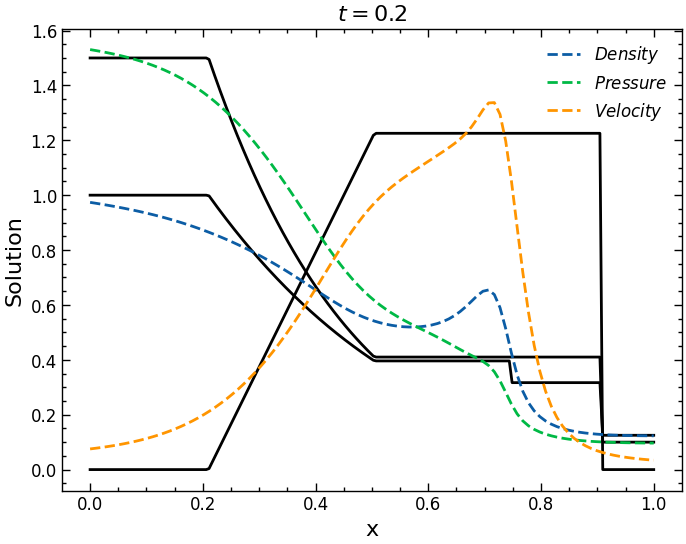

epoch 1001 loss_pde:0.84723593, loss_ic:0.01558777, loss_rh:0.00000000,loss_con:0.00004104
epoch 1002 loss_pde:0.82383982, loss_ic:0.01574969, loss_rh:0.00000000,loss_con:0.00000790
epoch 1003 loss_pde:0.79520539, loss_ic:0.01597673, loss_rh:0.00000000,loss_con:0.00005530
epoch 1004 loss_pde:0.82614669, loss_ic:0.01589846, loss_rh:0.00000000,loss_con:0.00006327
epoch 1005 loss_pde:0.81311720, loss_ic:0.01559874, loss_rh:0.00000000,loss_con:0.00009562
epoch 1006 loss_pde:0.84364613, loss_ic:0.01542288, loss_rh:0.00000000,loss_con:0.00003858
epoch 1007 loss_pde:0.82139775, loss_ic:0.01553544, loss_rh:0.00000000,loss_con:0.00000812
epoch 1008 loss_pde:0.79857024, loss_ic:0.01574206, loss_rh:0.00000000,loss_con:0.00002722
epoch 1009 loss_pde:0.81760336, loss_ic:0.01571450, loss_rh:0.00000000,loss_con:0.00003748
epoch 1010 loss_pde:0.80423223, loss_ic:0.01549033, loss_rh:0.00000000,loss_con:0.00007693
epoch 1011 loss_pde:0.83101620, loss_ic:0.01534466, loss_rh:0.00000000,loss_con:0.00003930

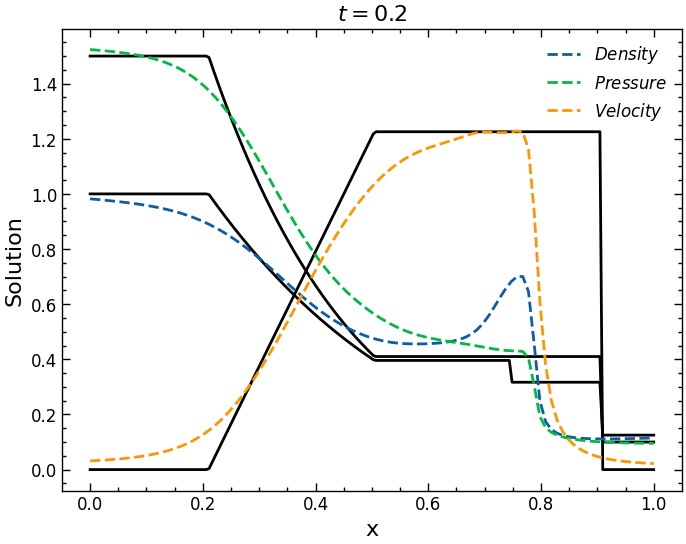

epoch 2001 loss_pde:0.32778370, loss_ic:0.00534473, loss_rh:0.00000042,loss_con:0.00000296
epoch 2002 loss_pde:0.32393797, loss_ic:0.00538250, loss_rh:0.00000042,loss_con:0.00000186
epoch 2003 loss_pde:0.32862766, loss_ic:0.00532005, loss_rh:0.00000043,loss_con:0.00000258
epoch 2004 loss_pde:0.32648273, loss_ic:0.00532393, loss_rh:0.00000043,loss_con:0.00000368
epoch 2005 loss_pde:0.32265901, loss_ic:0.00537452, loss_rh:0.00000043,loss_con:0.00000210
epoch 2006 loss_pde:0.33119495, loss_ic:0.00527823, loss_rh:0.00000043,loss_con:0.00000267
epoch 2007 loss_pde:0.31755983, loss_ic:0.00540852, loss_rh:0.00000043,loss_con:0.00000336
epoch 2008 loss_pde:0.32788681, loss_ic:0.00529093, loss_rh:0.00000044,loss_con:0.00000311
epoch 2009 loss_pde:0.32774001, loss_ic:0.00526930, loss_rh:0.00000044,loss_con:0.00000461
epoch 2010 loss_pde:0.31974373, loss_ic:0.00535801, loss_rh:0.00000044,loss_con:0.00000221
epoch 2011 loss_pde:0.33054414, loss_ic:0.00525285, loss_rh:0.00000045,loss_con:0.00000265

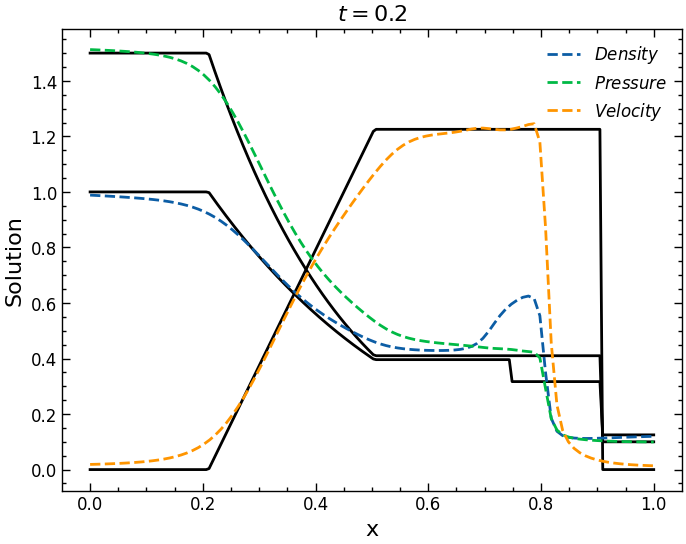

epoch 3001 loss_pde:0.19295350, loss_ic:0.00298073, loss_rh:0.00000110,loss_con:0.00000129
epoch 3002 loss_pde:0.19457165, loss_ic:0.00320453, loss_rh:0.00000110,loss_con:0.00000148
epoch 3003 loss_pde:0.20113670, loss_ic:0.00334706, loss_rh:0.00000110,loss_con:0.00000271
epoch 3004 loss_pde:0.19510321, loss_ic:0.00298510, loss_rh:0.00000110,loss_con:0.00000243
epoch 3005 loss_pde:0.20023496, loss_ic:0.00307995, loss_rh:0.00000110,loss_con:0.00000216
epoch 3006 loss_pde:0.20152093, loss_ic:0.00314706, loss_rh:0.00000108,loss_con:0.00000410
epoch 3007 loss_pde:0.18946494, loss_ic:0.00297621, loss_rh:0.00000107,loss_con:0.00000742
epoch 3008 loss_pde:0.18962720, loss_ic:0.00308699, loss_rh:0.00000106,loss_con:0.00000692
epoch 3009 loss_pde:0.19258785, loss_ic:0.00325519, loss_rh:0.00000106,loss_con:0.00000258
epoch 3010 loss_pde:0.19218855, loss_ic:0.00299719, loss_rh:0.00000107,loss_con:0.00000218
epoch 3011 loss_pde:0.19728083, loss_ic:0.00299952, loss_rh:0.00000108,loss_con:0.00000536

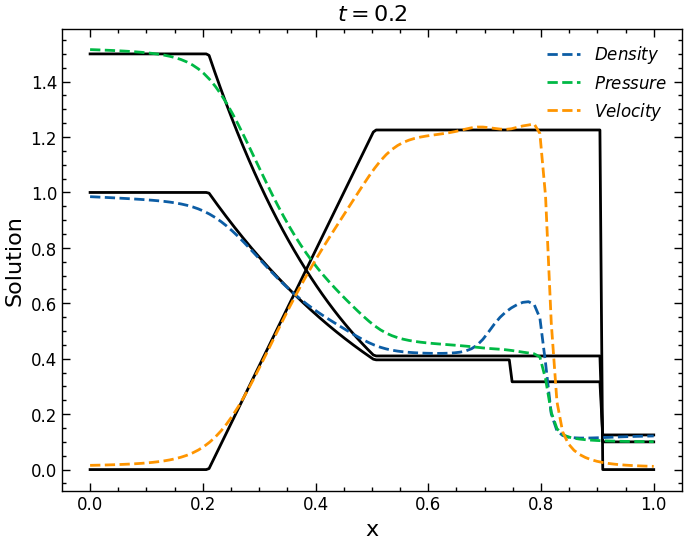

epoch 4001 loss_pde:0.17014152, loss_ic:0.00263986, loss_rh:0.00000082,loss_con:0.00000254
epoch 4002 loss_pde:0.16048630, loss_ic:0.00233331, loss_rh:0.00000082,loss_con:0.00000363
epoch 4003 loss_pde:0.14217989, loss_ic:0.00277073, loss_rh:0.00000082,loss_con:0.00000204
epoch 4004 loss_pde:0.16179223, loss_ic:0.00226311, loss_rh:0.00000081,loss_con:0.00000405
epoch 4005 loss_pde:0.15018208, loss_ic:0.00219664, loss_rh:0.00000080,loss_con:0.00001030
epoch 4006 loss_pde:0.15194465, loss_ic:0.00224827, loss_rh:0.00000081,loss_con:0.00000241
epoch 4007 loss_pde:0.16858483, loss_ic:0.00222629, loss_rh:0.00000082,loss_con:0.00000362
epoch 4008 loss_pde:0.17605939, loss_ic:0.00288793, loss_rh:0.00000082,loss_con:0.00000157
epoch 4009 loss_pde:0.15233319, loss_ic:0.00216822, loss_rh:0.00000080,loss_con:0.00000513
epoch 4010 loss_pde:0.15009588, loss_ic:0.00264965, loss_rh:0.00000081,loss_con:0.00000267
epoch 4011 loss_pde:0.15213678, loss_ic:0.00252560, loss_rh:0.00000081,loss_con:0.00000614

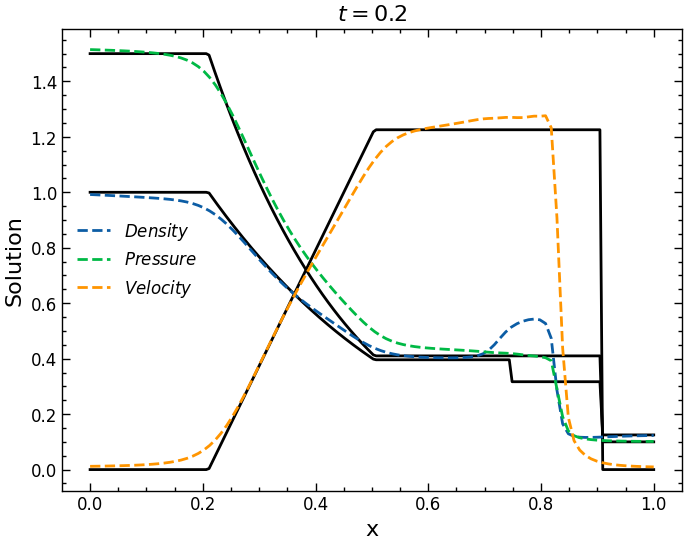

epoch 5001 loss_pde:0.11812264, loss_ic:0.00292826, loss_rh:0.00000049,loss_con:0.00000592
epoch 5002 loss_pde:0.10619548, loss_ic:0.00356415, loss_rh:0.00000046,loss_con:0.00001017
epoch 5003 loss_pde:0.10061490, loss_ic:0.00613031, loss_rh:0.00000046,loss_con:0.00002434
epoch 5004 loss_pde:0.09697296, loss_ic:0.00474198, loss_rh:0.00000044,loss_con:0.00001604
epoch 5005 loss_pde:0.09526335, loss_ic:0.00174230, loss_rh:0.00000046,loss_con:0.00001335
epoch 5006 loss_pde:0.12634324, loss_ic:0.00434296, loss_rh:0.00000045,loss_con:0.00001518
epoch 5007 loss_pde:0.12884626, loss_ic:0.00358614, loss_rh:0.00000046,loss_con:0.00000247
epoch 5008 loss_pde:0.09569048, loss_ic:0.00221471, loss_rh:0.00000045,loss_con:0.00000023
epoch 5009 loss_pde:0.10917001, loss_ic:0.00300552, loss_rh:0.00000045,loss_con:0.00000561
epoch 5010 loss_pde:0.10182937, loss_ic:0.00168417, loss_rh:0.00000046,loss_con:0.00000970
epoch 5011 loss_pde:0.15097412, loss_ic:0.00243879, loss_rh:0.00000047,loss_con:0.00000281

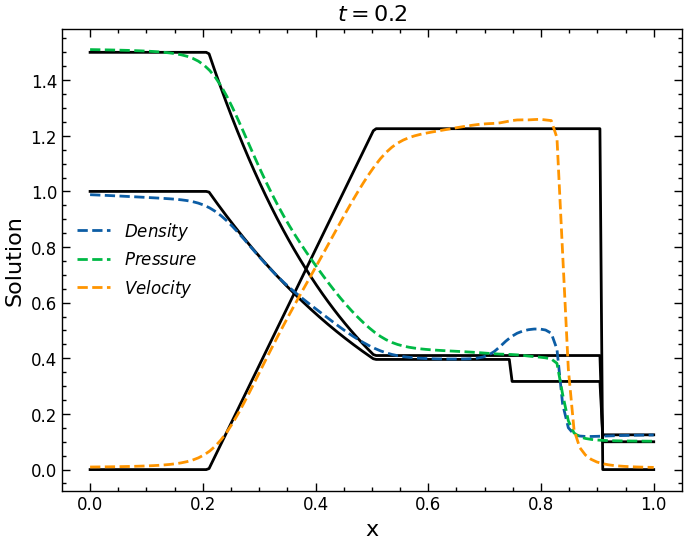

epoch 6001 loss_pde:0.13461331, loss_ic:0.00111619, loss_rh:0.00000043,loss_con:0.00007704
epoch 6002 loss_pde:0.09121311, loss_ic:0.00106363, loss_rh:0.00000043,loss_con:0.00002159
epoch 6003 loss_pde:0.10091030, loss_ic:0.00144640, loss_rh:0.00000046,loss_con:0.00003191
epoch 6004 loss_pde:0.09006818, loss_ic:0.00136037, loss_rh:0.00000044,loss_con:0.00004594
epoch 6005 loss_pde:0.10025077, loss_ic:0.00156263, loss_rh:0.00000045,loss_con:0.00000544
epoch 6006 loss_pde:0.09099107, loss_ic:0.00121388, loss_rh:0.00000042,loss_con:0.00002558
epoch 6007 loss_pde:0.12504089, loss_ic:0.00173768, loss_rh:0.00000044,loss_con:0.00002400
epoch 6008 loss_pde:0.07422244, loss_ic:0.00124835, loss_rh:0.00000042,loss_con:0.00001739
epoch 6009 loss_pde:0.10099255, loss_ic:0.00168247, loss_rh:0.00000044,loss_con:0.00003263
epoch 6010 loss_pde:0.08532934, loss_ic:0.00155310, loss_rh:0.00000042,loss_con:0.00001085
epoch 6011 loss_pde:0.09056099, loss_ic:0.00107627, loss_rh:0.00000044,loss_con:0.00003295

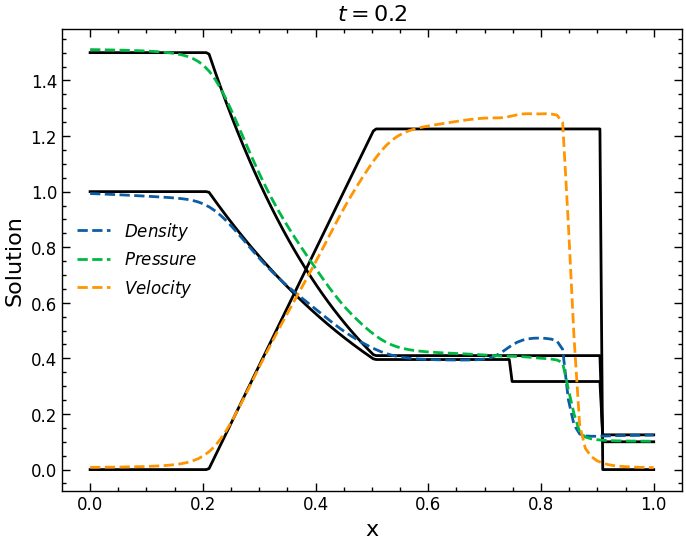

epoch 7001 loss_pde:0.06361648, loss_ic:0.00124530, loss_rh:0.00000026,loss_con:0.00000405
epoch 7002 loss_pde:0.06655156, loss_ic:0.00146600, loss_rh:0.00000026,loss_con:0.00000644
epoch 7003 loss_pde:0.06705889, loss_ic:0.00096909, loss_rh:0.00000026,loss_con:0.00000066
epoch 7004 loss_pde:0.07068061, loss_ic:0.00119472, loss_rh:0.00000026,loss_con:0.00000461
epoch 7005 loss_pde:0.06885376, loss_ic:0.00095795, loss_rh:0.00000026,loss_con:0.00000203
epoch 7006 loss_pde:0.07242644, loss_ic:0.00109253, loss_rh:0.00000026,loss_con:0.00000042
epoch 7007 loss_pde:0.07776826, loss_ic:0.00094330, loss_rh:0.00000026,loss_con:0.00000459
epoch 7008 loss_pde:0.07049810, loss_ic:0.00127581, loss_rh:0.00000026,loss_con:0.00000245
epoch 7009 loss_pde:0.07600185, loss_ic:0.00095848, loss_rh:0.00000026,loss_con:0.00000214
epoch 7010 loss_pde:0.08713814, loss_ic:0.00086316, loss_rh:0.00000026,loss_con:0.00000542
epoch 7011 loss_pde:0.07556326, loss_ic:0.00084253, loss_rh:0.00000026,loss_con:0.00000042

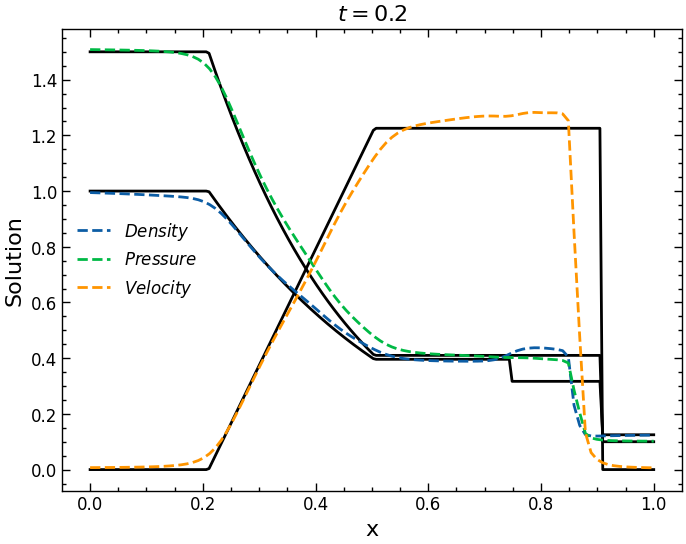

epoch 8001 loss_pde:0.05426130, loss_ic:0.00066582, loss_rh:0.00000014,loss_con:0.00000015
epoch 8002 loss_pde:0.05424694, loss_ic:0.00066522, loss_rh:0.00000014,loss_con:0.00000018
epoch 8003 loss_pde:0.05412896, loss_ic:0.00066617, loss_rh:0.00000014,loss_con:0.00000015
epoch 8004 loss_pde:0.05414189, loss_ic:0.00066558, loss_rh:0.00000014,loss_con:0.00000015
epoch 8005 loss_pde:0.05414234, loss_ic:0.00066496, loss_rh:0.00000014,loss_con:0.00000017
epoch 8006 loss_pde:0.05410273, loss_ic:0.00066518, loss_rh:0.00000014,loss_con:0.00000014
epoch 8007 loss_pde:0.05405579, loss_ic:0.00066495, loss_rh:0.00000014,loss_con:0.00000016
epoch 8008 loss_pde:0.05417838, loss_ic:0.00066335, loss_rh:0.00000014,loss_con:0.00000016
epoch 8009 loss_pde:0.05406853, loss_ic:0.00066405, loss_rh:0.00000014,loss_con:0.00000015
epoch 8010 loss_pde:0.05407145, loss_ic:0.00066344, loss_rh:0.00000014,loss_con:0.00000016
epoch 8011 loss_pde:0.05418027, loss_ic:0.00066205, loss_rh:0.00000014,loss_con:0.00000015

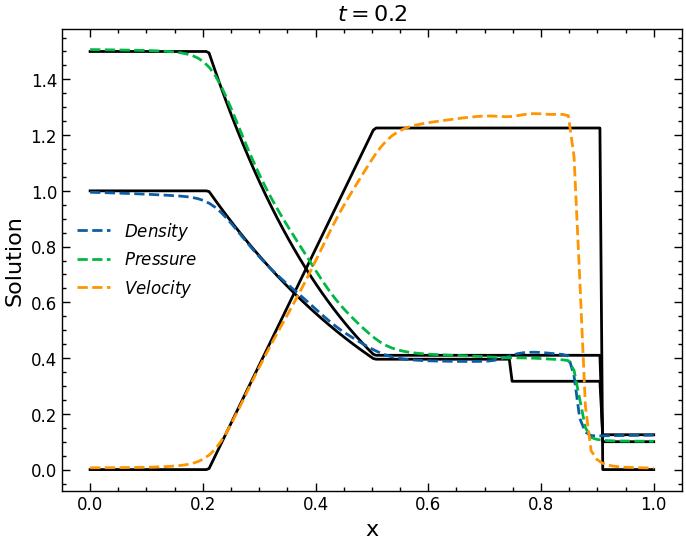

epoch 9001 loss_pde:0.04624546, loss_ic:0.00058164, loss_rh:0.00000015,loss_con:0.00000037
epoch 9002 loss_pde:0.04862088, loss_ic:0.00064808, loss_rh:0.00000015,loss_con:0.00000015
epoch 9003 loss_pde:0.04762944, loss_ic:0.00067584, loss_rh:0.00000015,loss_con:0.00000015
epoch 9004 loss_pde:0.04588312, loss_ic:0.00057120, loss_rh:0.00000015,loss_con:0.00000029
epoch 9005 loss_pde:0.04619713, loss_ic:0.00058012, loss_rh:0.00000015,loss_con:0.00000037
epoch 9006 loss_pde:0.04859746, loss_ic:0.00064609, loss_rh:0.00000015,loss_con:0.00000015
epoch 9007 loss_pde:0.04761598, loss_ic:0.00067330, loss_rh:0.00000015,loss_con:0.00000015
epoch 9008 loss_pde:0.04585106, loss_ic:0.00056994, loss_rh:0.00000015,loss_con:0.00000029
epoch 9009 loss_pde:0.04614691, loss_ic:0.00057851, loss_rh:0.00000015,loss_con:0.00000037
epoch 9010 loss_pde:0.04857407, loss_ic:0.00064411, loss_rh:0.00000015,loss_con:0.00000015
epoch 9011 loss_pde:0.04760737, loss_ic:0.00067064, loss_rh:0.00000015,loss_con:0.00000015

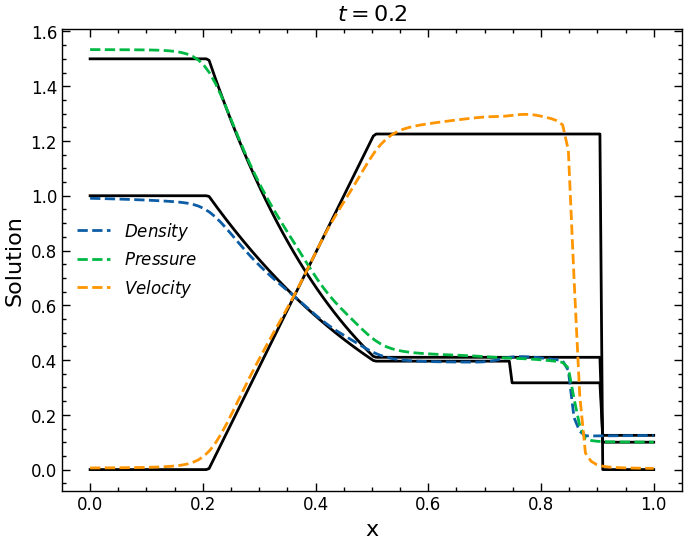

epoch 10001 loss_pde:0.10131074, loss_ic:0.01265287, loss_rh:0.00000023,loss_con:0.00004711
epoch 10002 loss_pde:0.09352204, loss_ic:0.00849598, loss_rh:0.00000021,loss_con:0.00004623
epoch 10003 loss_pde:0.06382102, loss_ic:0.00209640, loss_rh:0.00000021,loss_con:0.00001336
epoch 10004 loss_pde:0.06635575, loss_ic:0.00440637, loss_rh:0.00000020,loss_con:0.00002540
epoch 10005 loss_pde:0.07681144, loss_ic:0.00694740, loss_rh:0.00000016,loss_con:0.00005837
epoch 10006 loss_pde:0.09477766, loss_ic:0.00728512, loss_rh:0.00000017,loss_con:0.00001458
epoch 10007 loss_pde:0.08768968, loss_ic:0.00498067, loss_rh:0.00000017,loss_con:0.00002196
epoch 10008 loss_pde:0.06743012, loss_ic:0.00175635, loss_rh:0.00000017,loss_con:0.00004672
epoch 10009 loss_pde:0.09804367, loss_ic:0.00317537, loss_rh:0.00000021,loss_con:0.00001164
epoch 10010 loss_pde:0.06693414, loss_ic:0.00344876, loss_rh:0.00000023,loss_con:0.00000578
epoch 10011 loss_pde:0.04981582, loss_ic:0.00196923, loss_rh:0.00000025,loss_con

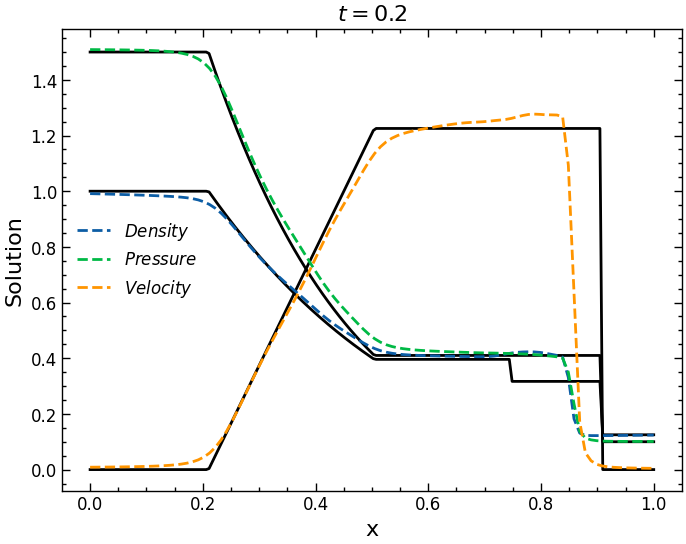

epoch 11001 loss_pde:0.07155483, loss_ic:0.00037080, loss_rh:0.00000050,loss_con:0.00000048
epoch 11002 loss_pde:0.07151293, loss_ic:0.00037057, loss_rh:0.00000050,loss_con:0.00000048
epoch 11003 loss_pde:0.07147123, loss_ic:0.00037034, loss_rh:0.00000050,loss_con:0.00000048
epoch 11004 loss_pde:0.07143053, loss_ic:0.00037011, loss_rh:0.00000050,loss_con:0.00000048
epoch 11005 loss_pde:0.07138868, loss_ic:0.00036989, loss_rh:0.00000049,loss_con:0.00000048
epoch 11006 loss_pde:0.07134807, loss_ic:0.00036965, loss_rh:0.00000049,loss_con:0.00000047
epoch 11007 loss_pde:0.07130667, loss_ic:0.00036943, loss_rh:0.00000049,loss_con:0.00000047
epoch 11008 loss_pde:0.07126526, loss_ic:0.00036920, loss_rh:0.00000049,loss_con:0.00000047
epoch 11009 loss_pde:0.07122437, loss_ic:0.00036897, loss_rh:0.00000049,loss_con:0.00000047
epoch 11010 loss_pde:0.07118239, loss_ic:0.00036876, loss_rh:0.00000049,loss_con:0.00000047
epoch 11011 loss_pde:0.07114139, loss_ic:0.00036853, loss_rh:0.00000049,loss_con

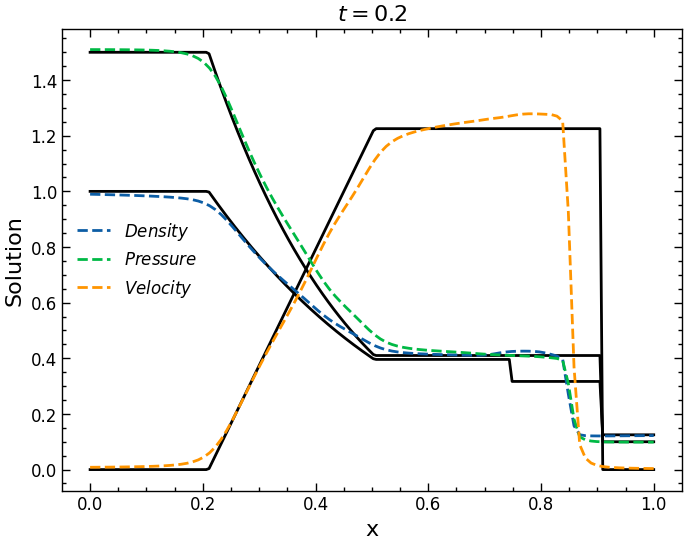

epoch 12001 loss_pde:0.07293022, loss_ic:0.00032171, loss_rh:0.00000052,loss_con:0.00000057
epoch 12002 loss_pde:0.07287959, loss_ic:0.00032145, loss_rh:0.00000052,loss_con:0.00000057
epoch 12003 loss_pde:0.07282752, loss_ic:0.00032120, loss_rh:0.00000052,loss_con:0.00000057
epoch 12004 loss_pde:0.07277509, loss_ic:0.00032095, loss_rh:0.00000052,loss_con:0.00000057
epoch 12005 loss_pde:0.07272391, loss_ic:0.00032070, loss_rh:0.00000052,loss_con:0.00000057
epoch 12006 loss_pde:0.07267369, loss_ic:0.00032044, loss_rh:0.00000052,loss_con:0.00000057
epoch 12007 loss_pde:0.07262356, loss_ic:0.00032019, loss_rh:0.00000052,loss_con:0.00000056
epoch 12008 loss_pde:0.07257210, loss_ic:0.00031994, loss_rh:0.00000052,loss_con:0.00000056
epoch 12009 loss_pde:0.07252072, loss_ic:0.00031970, loss_rh:0.00000052,loss_con:0.00000056
epoch 12010 loss_pde:0.07247035, loss_ic:0.00031946, loss_rh:0.00000052,loss_con:0.00000056
epoch 12011 loss_pde:0.07242033, loss_ic:0.00031921, loss_rh:0.00000052,loss_con

In [ ]:
model =  PINNs_IM_Euler_1D(Nl=7,Nn=50).to(device).double()
print('Start training...')
ind = 0
epoch = 0
epochi = epoch
lr = 0.001                                                         # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 50000
loss_history=[]
tic = time.time()

for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    #print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.2 and ind ==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
        ind =1
        print(f'loss_tot:{loss:.8f},lr:0.001')
    if loss < 0.05 and ind ==1:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
        ind =2
        print(f'loss_tot:{loss:.8f},lr:0.0001')
    if loss >10 and ind >0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        ind = 0
        print(f'loss_tot:{loss:.8f},lr:0.005')
    if loss <0.007:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')

In [ ]:
print({stop})

NameError: name 'stop' is not defined

loss_tot:0.04999197
loss_tot:455574425.65822625
loss_tot:38685202.70482346
loss_tot:4039245.37005552
loss_tot:422556.26251630
loss_tot:210116.27556589
loss_tot:58455.42448551
loss_tot:9411.16838818
loss_tot:1195.73239360
loss_tot:153.92524178
loss_tot:33.91266889
loss_tot:17.05113863
loss_tot:14.01142509
loss_tot:5.33573351
loss_tot:3.03096707
loss_tot:2.28771473
loss_tot:1.77690624
loss_tot:1.36267591
loss_tot:1.09934960
loss_tot:0.90089021
loss_tot:0.75163707
loss_tot:0.61633457
loss_tot:0.52691040
loss_tot:0.41950428
loss_tot:0.35184628
loss_tot:0.31547183
loss_tot:0.26475669
loss_tot:0.23647282
loss_tot:0.21684706
epoch 13000 loss:0.19640981


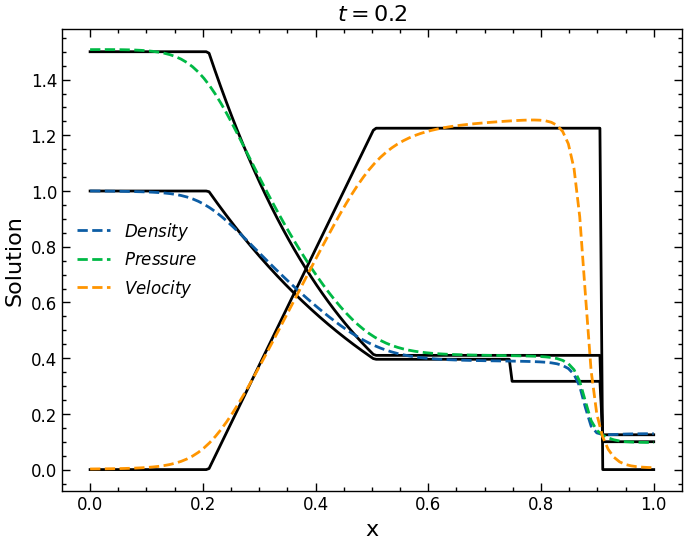

loss_tot:0.19640981
loss_tot:0.17807527
loss_tot:0.16573304
loss_tot:0.15369934
loss_tot:0.14445053
loss_tot:0.13804586
loss_tot:0.13404801
loss_tot:0.12826367
loss_tot:0.12130570
loss_tot:0.10552234
loss_tot:0.09574183
loss_tot:0.09055354
loss_tot:0.08574844
loss_tot:0.52686026
loss_tot:0.14536920
loss_tot:0.09920847
loss_tot:0.08512164
loss_tot:0.08132884
loss_tot:0.07760588
loss_tot:0.07470567
loss_tot:0.07081065
loss_tot:0.06813172
loss_tot:0.06555043
loss_tot:0.06404560
loss_tot:0.06148047
loss_tot:0.05875226
loss_tot:0.05551050
loss_tot:0.05296384
loss_tot:0.04960320
loss_tot:0.04731825
loss_tot:0.04430672
loss_tot:0.04266873
loss_tot:0.04056396
loss_tot:0.03721888
loss_tot:0.03458837
loss_tot:0.03329327
loss_tot:0.03083839
loss_tot:0.02951772
loss_tot:0.02810197
loss_tot:0.02704270
loss_tot:0.02634944
loss_tot:0.02581439
loss_tot:0.02515317
loss_tot:0.02439471
loss_tot:0.02344263
loss_tot:0.02290891
loss_tot:0.02250497
loss_tot:0.02182644
loss_tot:0.02105099
loss_tot:0.02048141


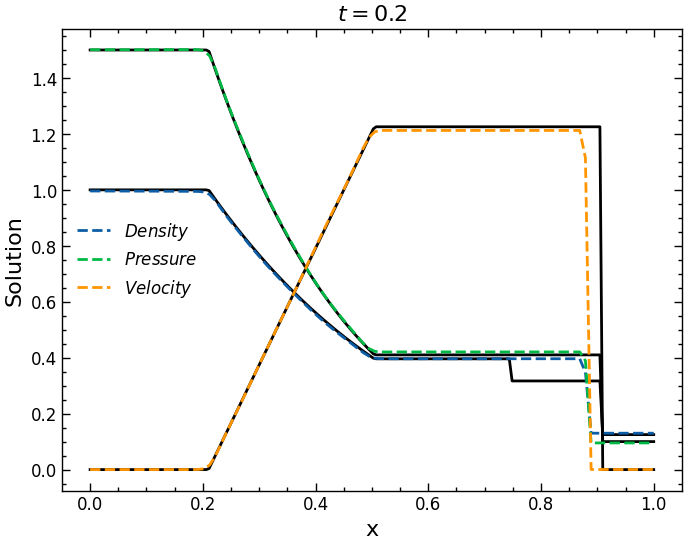

loss_tot:0.00469653
loss_tot:0.00468964
loss_tot:0.00468578
loss_tot:0.00468078
loss_tot:0.00467597
loss_tot:0.00467434
loss_tot:0.00466935
loss_tot:0.00466557
loss_tot:0.00466101
loss_tot:0.00465560
loss_tot:0.00465416
loss_tot:0.00465117
loss_tot:0.00464842
loss_tot:0.00464750
loss_tot:0.00464574
loss_tot:0.00464368
loss_tot:0.00463660
loss_tot:0.00463044
loss_tot:0.00462443
loss_tot:0.00461788
loss_tot:0.00461560
loss_tot:0.00460952
loss_tot:0.00460436
loss_tot:0.00459987
loss_tot:0.00459234
loss_tot:0.00458925
loss_tot:0.00458769
loss_tot:0.00458474
loss_tot:0.00458386
loss_tot:0.00457864
loss_tot:0.00457285
loss_tot:0.00456870
loss_tot:0.00456589
loss_tot:0.00456209
loss_tot:0.00455782
loss_tot:0.00455712
loss_tot:0.00455484
loss_tot:0.00455423
loss_tot:0.00455326
loss_tot:0.00455258
loss_tot:0.00455060
loss_tot:0.00454978
loss_tot:0.00454890
loss_tot:0.00454575
loss_tot:0.00453822
loss_tot:0.00453203
loss_tot:0.00453014
loss_tot:0.00452866
loss_tot:0.00452506
loss_tot:0.00452131


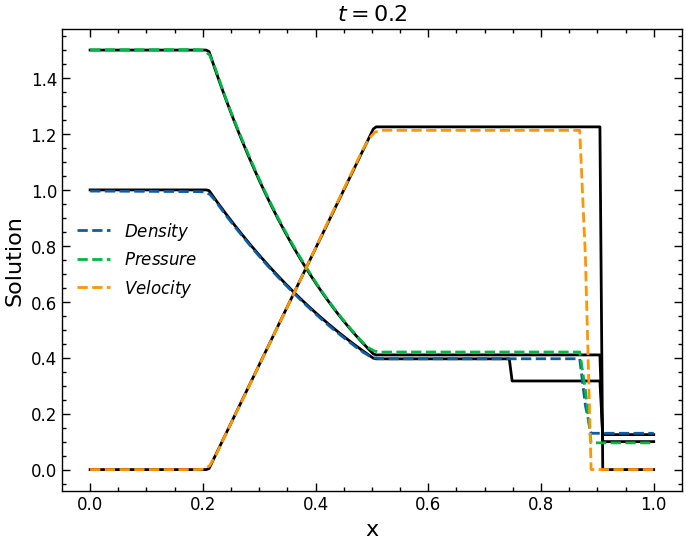

loss_tot:0.00391970
loss_tot:0.00391926
loss_tot:0.00391853
loss_tot:0.00391812
loss_tot:0.00391741
loss_tot:0.00391702
loss_tot:0.00391643
loss_tot:0.00391538
loss_tot:0.00391746
loss_tot:0.00391184
loss_tot:0.00391116
loss_tot:0.00391101
loss_tot:0.00391069
loss_tot:0.00391008
loss_tot:0.00390897
loss_tot:0.00390816
loss_tot:0.00390703
loss_tot:0.00398481
loss_tot:0.00390757
loss_tot:0.00390588
loss_tot:0.00390819
loss_tot:0.00390468
loss_tot:0.00390439
loss_tot:0.00390383
loss_tot:0.00390288
loss_tot:0.00390256
loss_tot:0.00390127
loss_tot:0.00390056
loss_tot:0.00390021
loss_tot:0.00389973
loss_tot:0.00389964
loss_tot:0.00389953
loss_tot:0.00389928
loss_tot:0.00389901
loss_tot:0.00389872
loss_tot:0.00389841
loss_tot:0.00389823
loss_tot:0.00389808
loss_tot:0.00389781
loss_tot:0.00389764
loss_tot:0.00389697
loss_tot:0.00389671
loss_tot:0.00389653
loss_tot:0.00389633
loss_tot:0.00389618
loss_tot:0.00389583
loss_tot:0.00389552
loss_tot:0.00389524
loss_tot:0.00389449
loss_tot:0.00389159


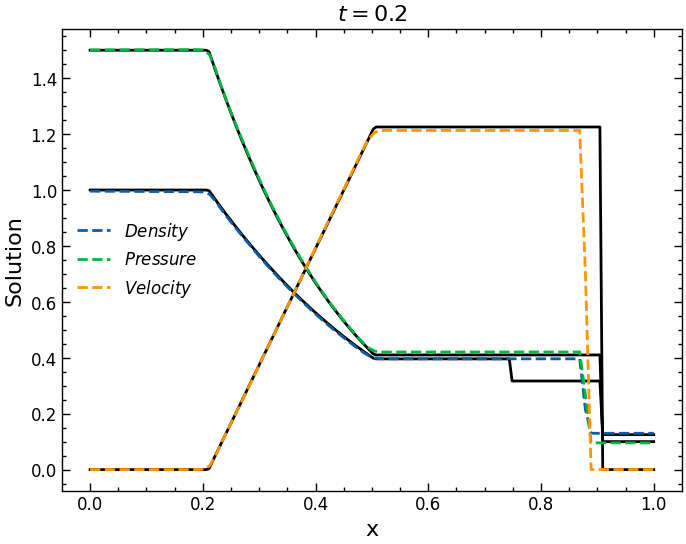

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


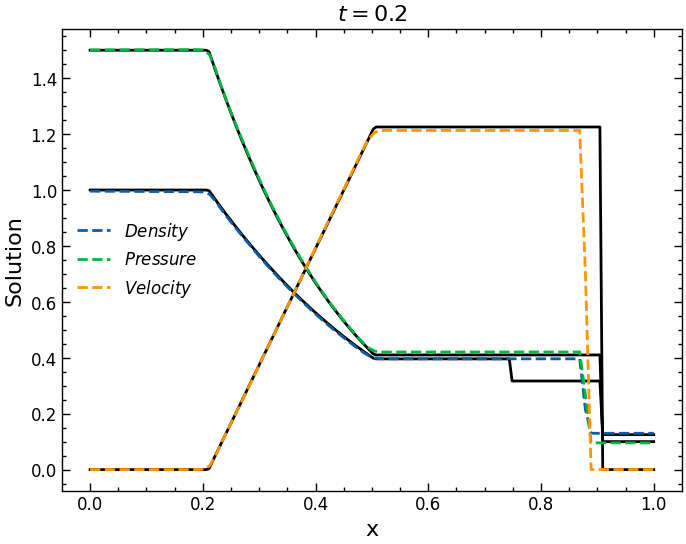

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


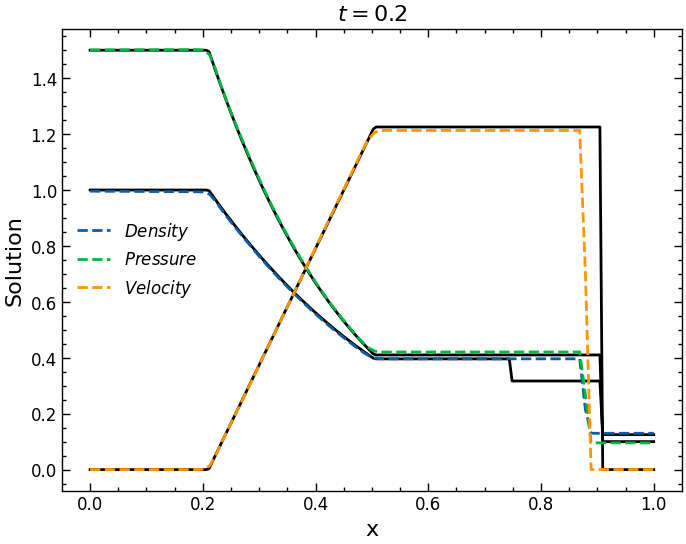

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


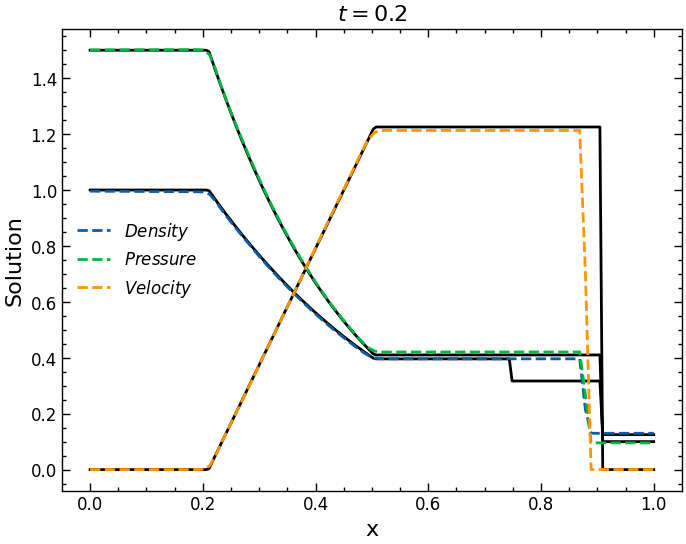

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


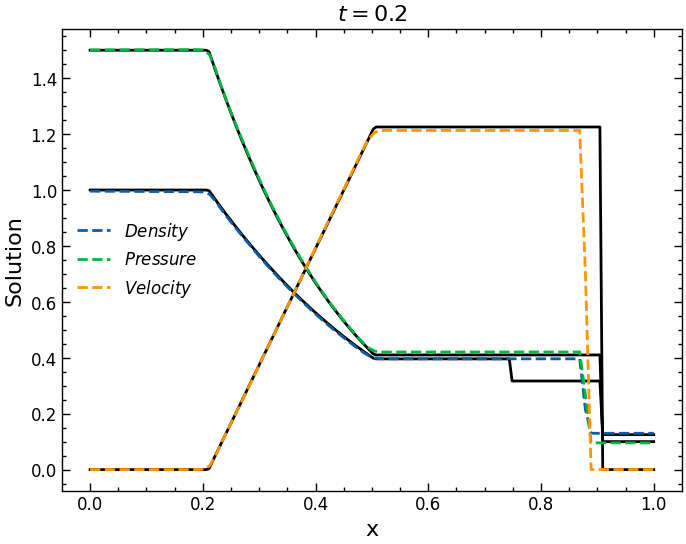

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


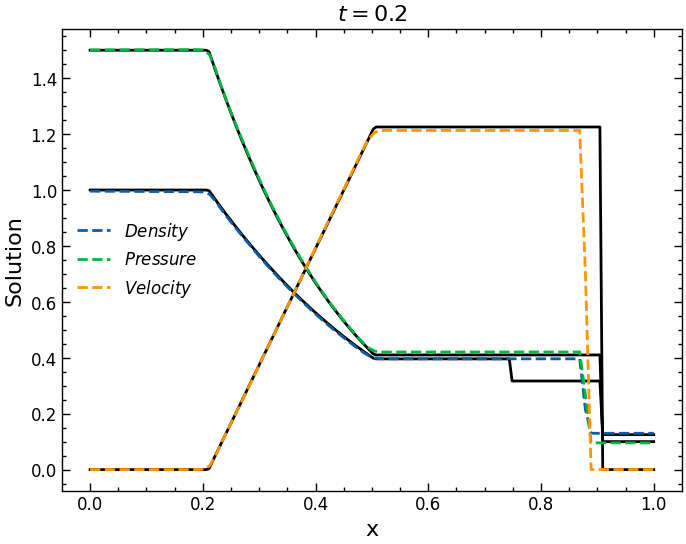

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


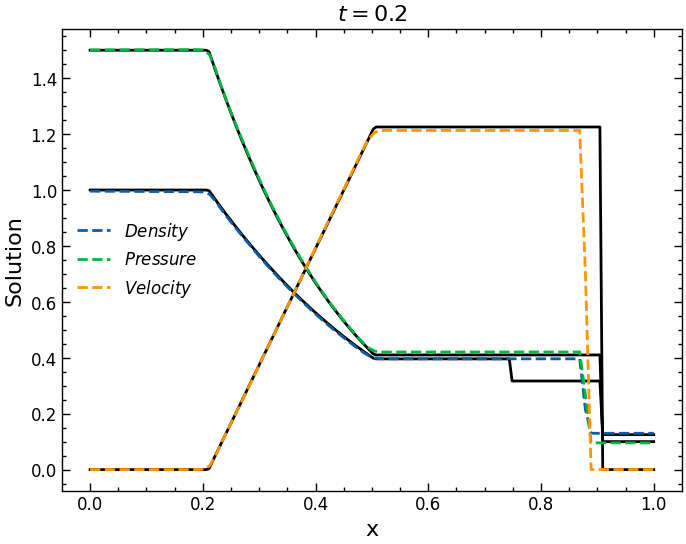

loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830
loss_tot:0.00378830


In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)
epochi = epoch
epochs = 5000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train2(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
  #  if loss < 0.005:
   #     break
toc = time.time()

print(f'Total training time: {toc - tic}')

loss_tot:0.04335479
loss_tot:0.04148863
loss_tot:0.04061782
loss_tot:0.03922743
loss_tot:0.03778986
loss_tot:0.03558605
loss_tot:0.03312103
loss_tot:0.03090051
loss_tot:0.02885456
loss_tot:0.02690522
loss_tot:0.02550608
loss_tot:0.02428947
loss_tot:0.02325693
loss_tot:0.02272124
loss_tot:0.02212369
loss_tot:0.02133174
loss_tot:0.02074052
loss_tot:0.02005352
loss_tot:0.01927309
loss_tot:0.01871574
loss_tot:0.01798318
loss_tot:0.01760617
loss_tot:0.01715154
loss_tot:0.01670622
loss_tot:0.01634921
loss_tot:0.01587166
loss_tot:0.01540655
loss_tot:0.01499038
loss_tot:0.01465341
loss_tot:0.01426934
loss_tot:0.01396440
loss_tot:0.01375017
loss_tot:0.01346678
loss_tot:0.01331923
loss_tot:0.01320968
loss_tot:0.01299578
loss_tot:0.01262412
loss_tot:0.01240541
loss_tot:0.01217008
loss_tot:0.01176532
loss_tot:0.01154771
loss_tot:0.01136216
loss_tot:0.01121302
loss_tot:0.01101444
loss_tot:0.01077609
loss_tot:0.01055573
loss_tot:0.01037105
loss_tot:0.01011347
loss_tot:0.00988139
loss_tot:0.00957858


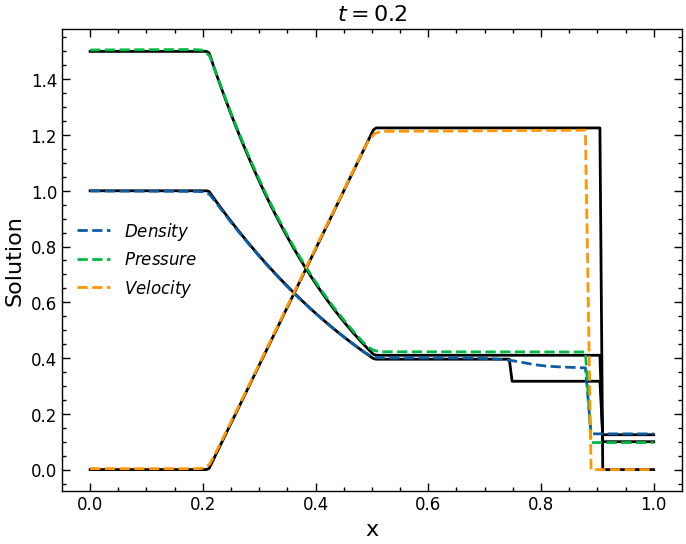

loss_tot:0.00211114
loss_tot:0.00210918
loss_tot:0.00210628
loss_tot:0.00210482
loss_tot:0.00210302
loss_tot:0.00210039
loss_tot:0.00209817
loss_tot:0.00209609
loss_tot:0.00209446
loss_tot:0.00209374
loss_tot:0.00209319
loss_tot:0.00209265
loss_tot:0.00209227
loss_tot:0.00209178
loss_tot:0.00209118
loss_tot:0.00209011
loss_tot:0.00208874
loss_tot:0.00209011
loss_tot:0.00208474
loss_tot:0.00208420
loss_tot:0.00208319
loss_tot:0.00208216
loss_tot:0.00208111
loss_tot:0.00208041
loss_tot:0.00207970
loss_tot:0.00207833
loss_tot:0.00207609
loss_tot:0.00207506
loss_tot:0.00207421
loss_tot:0.00207155
loss_tot:0.00206950
loss_tot:0.00206810
loss_tot:0.00206587
loss_tot:0.00206384
loss_tot:0.00206098
loss_tot:0.00205924
loss_tot:0.00205842
loss_tot:0.00205682
loss_tot:0.00205522
loss_tot:0.00205229
loss_tot:0.00204833
loss_tot:0.00204662
loss_tot:0.00204357
loss_tot:0.00204057
loss_tot:0.00203838
loss_tot:0.00203504
loss_tot:0.00203237
loss_tot:0.00203141
loss_tot:0.00203060
loss_tot:0.00202986


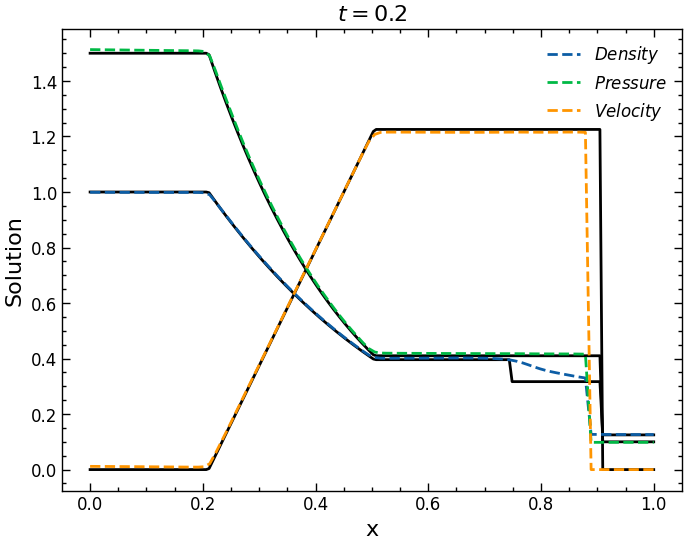

loss_tot:0.00134783
loss_tot:0.00134767
loss_tot:0.00134719
loss_tot:0.00134698
loss_tot:0.00134678
loss_tot:0.00134649
loss_tot:0.00134638
loss_tot:0.00134616
loss_tot:0.00134564
loss_tot:0.00134481
loss_tot:0.00134374
loss_tot:0.00134298
loss_tot:0.00134221
loss_tot:0.00134139
loss_tot:0.00134005
loss_tot:0.00133860
loss_tot:0.00133712
loss_tot:0.00133548
loss_tot:0.00133440
loss_tot:0.00133366
loss_tot:0.00133230
loss_tot:0.00133088
loss_tot:0.00132962
loss_tot:0.00132903
loss_tot:0.00132811
loss_tot:0.00132722
loss_tot:0.00132648
loss_tot:0.00132540
loss_tot:0.00132416
loss_tot:0.00132335
loss_tot:0.00132270
loss_tot:0.00132188
loss_tot:0.00132057
loss_tot:0.00131972
loss_tot:0.00131861
loss_tot:0.00131799
loss_tot:0.00131720
loss_tot:0.00131661
loss_tot:0.00131588
loss_tot:0.00131494
loss_tot:0.00131418
loss_tot:0.00131357
loss_tot:0.00131303
loss_tot:0.00131246
loss_tot:0.00131222
loss_tot:0.00131195
loss_tot:0.00131179
loss_tot:0.00131163
loss_tot:0.00131157
loss_tot:0.00131143


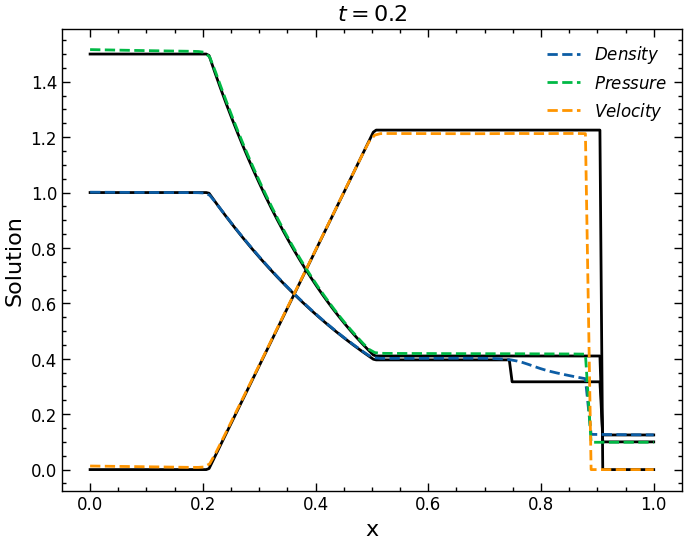

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


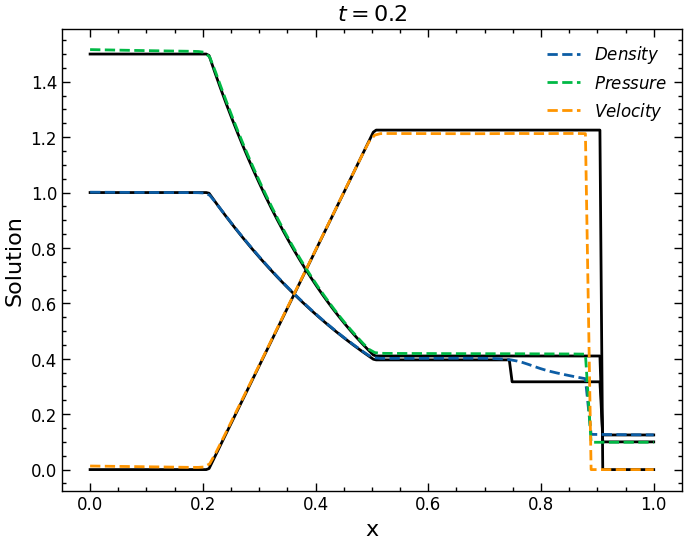

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


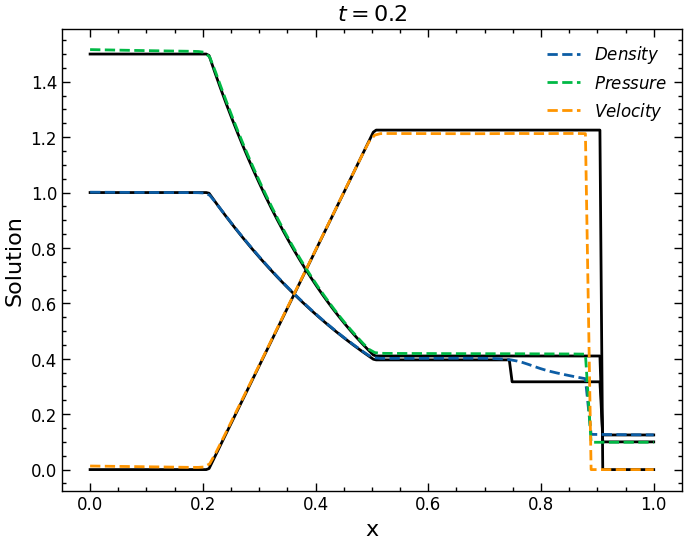

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


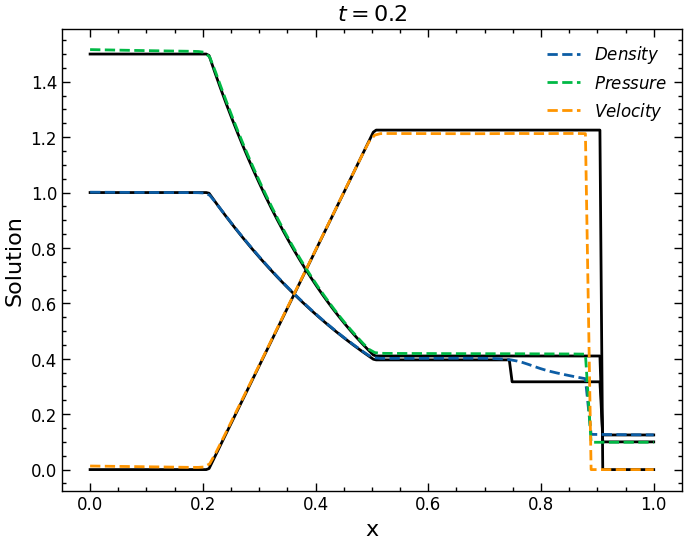

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


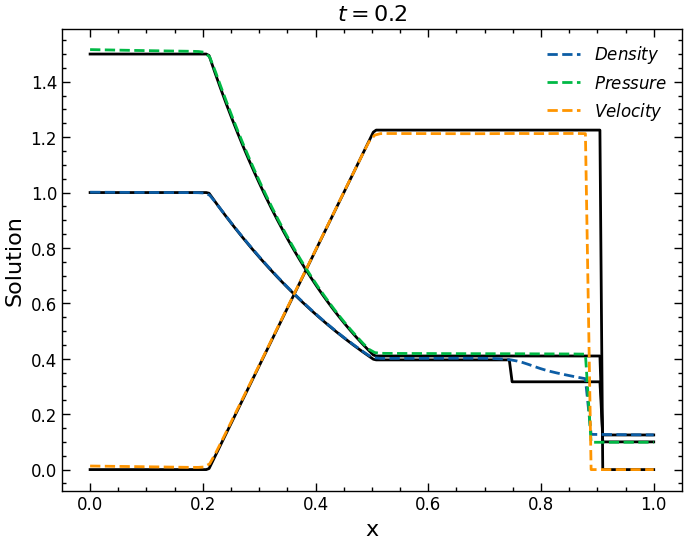

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


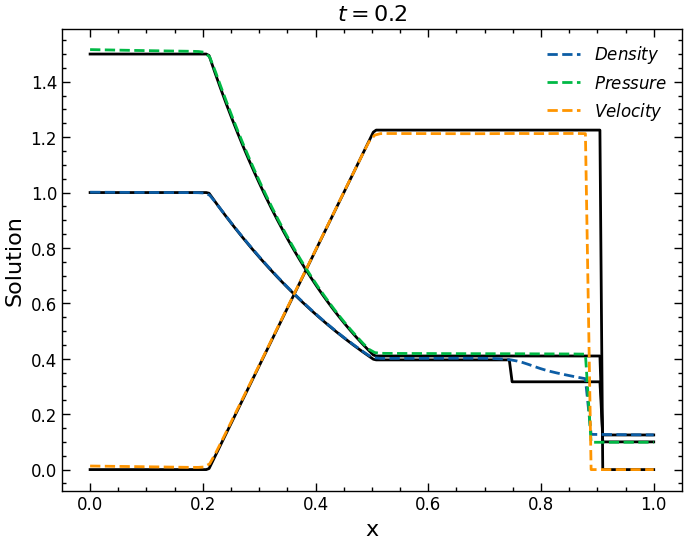

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


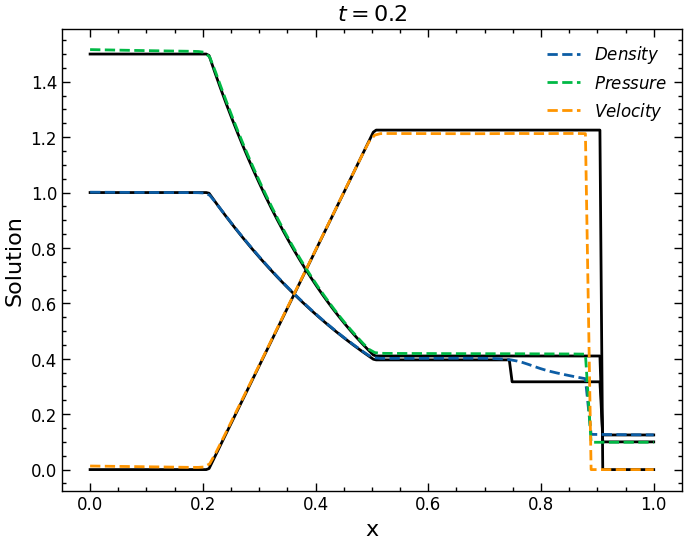

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852


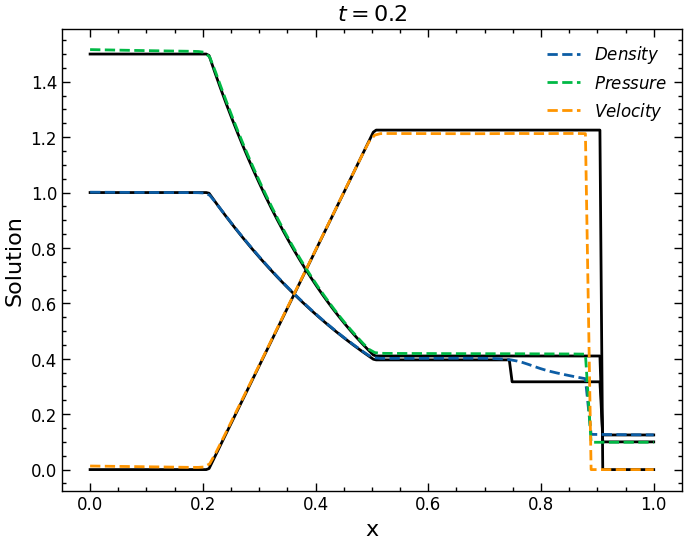

loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
loss_tot:0.00113852
Total training time: 909.6915097236633


In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)
epochi = epoch
epochs = 5000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train2(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
  #  if loss < 0.005:
   #     break
toc = time.time()

print(f'Total training time: {toc - tic}')

In [ ]:
print({stop})

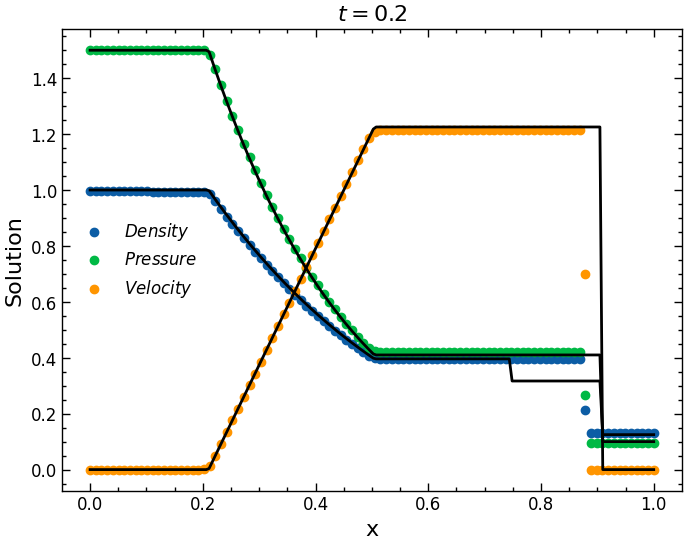

In [ ]:
plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"


#plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
plt.scatter(x[:],model(x_test)[:,:1].detach().cpu(),label=fr"$Density$")
#plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
plt.scatter(x[:],model(x_test)[:,1:2].detach().cpu(),label=fr"$Pressure$")
#plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
plt.scatter(x[:],model(x_test)[:,2:].detach().cpu(),label=fr"$Velocity$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("Solution", fontsize=16)
plt.title(fr"$t={Te}$")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

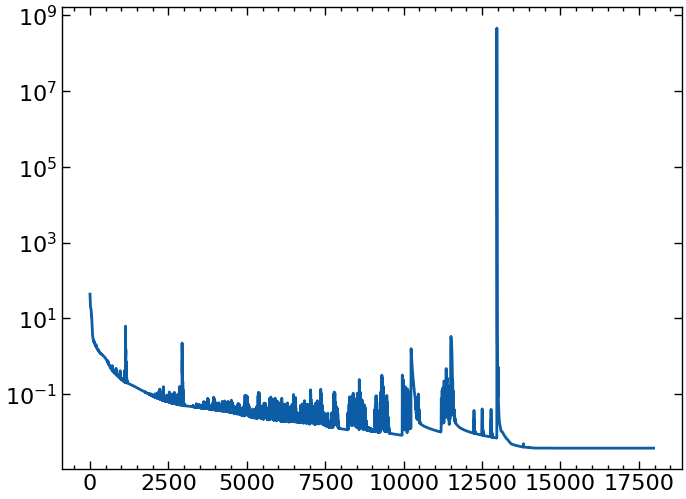

In [ ]:
plt.plot(loss_history)
plt.yscale('log')

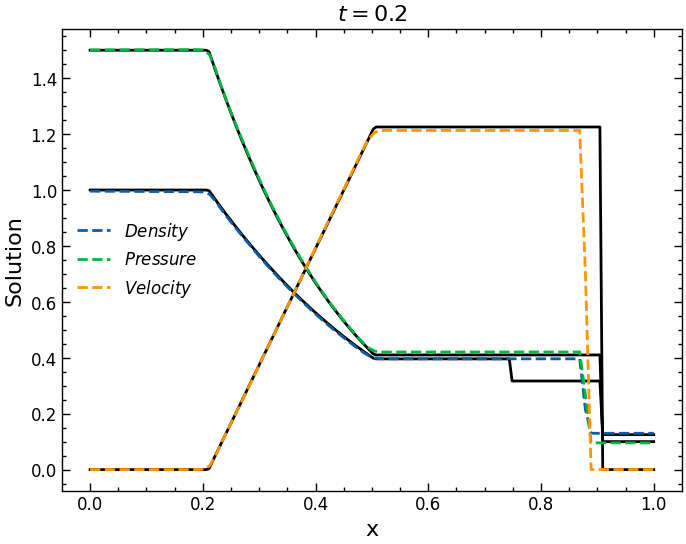

In [ ]:
#from E_data_LHS import Euler_WENO
#weno_u = Euler_WENO(Xs,Xe,Ts,Te,ini,gamma,delta_t=0.0001,delta_x=0.005)

ind = 100
plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"

Nt_test = 100
x = np.linspace(0.0, 1.0, Nt_test)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(device)
#u_pred = to_numpy(model(x_test))
#plt.plot(x[:],torch.exp(model(x_test)[:,:1]).detach().cpu(),'--',label=fr"$Density$")
#plt.plot(x[:],torch.exp(model(x_test)[:,1:2]).detach().cpu(),'--',label=fr"$Pressure$")
#plt.plot(x[:],torch.exp(model(x_test)[:,2:]).detach().cpu(),'--',label=fr"$Velocity$")
plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
plt.xlabel("x",     fontsize=16)
plt.ylabel("Solution", fontsize=16)
plt.title(fr"$t={round((ind-1)*(Te-Ts)/(Nt_test-1),3)}$")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

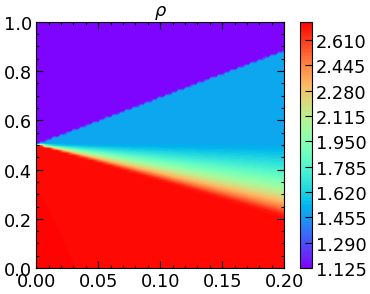

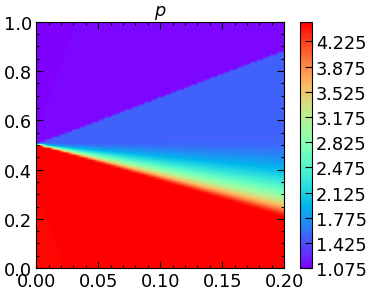

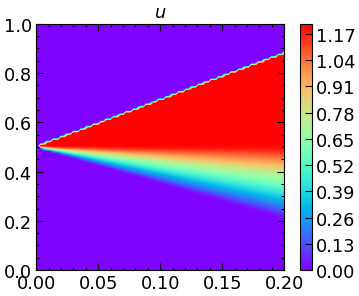

In [ ]:
from E_data import create_residual_data
xt_test = create_residual_data(Xs, Xe, Ts, Te, 100,100,100,100,10000)[2].to(device) 

E_plot(xt_test, torch.exp(model(xt_test)[:,:1]), dpi=80, figsize=(5,4),title=fr"$\rho$")
E_plot(xt_test, torch.exp(model(xt_test)[:,1:2]), dpi=80, figsize=(5,4),title=fr"$p$")
E_plot(xt_test, model(xt_test)[:,2:], dpi=80, figsize=(5,4),title=fr"$u$")

In [ ]:
from E_TGPT_activation import P
layers_pinn = np.array([2, 50, 50,50, 50, 50,50, 3])

w1 = model.net.Linear_layer_1.weight.detach().cpu()
w2 = model.net.Linear_layer_2.weight.detach().cpu()
w3 = model.net.Linear_layer_3.weight.detach().cpu()
w4 = model.net.Linear_layer_4.weight.detach().cpu()
w5 = model.net.Linear_layer_5.weight.detach().cpu()
w6 = model.net.Linear_layer_6.weight.detach().cpu()
w7 = model.net.Linear_layer_final.weight.detach().cpu()


b1 = model.net.Linear_layer_1.bias.detach().cpu()
b2 = model.net.Linear_layer_2.bias.detach().cpu()
b3 = model.net.Linear_layer_3.bias.detach().cpu()
b4 = model.net.Linear_layer_4.bias.detach().cpu()
b5 = model.net.Linear_layer_5.bias.detach().cpu()
b6 = model.net.Linear_layer_6.bias.detach().cpu()
b7 = model.net.Linear_layer_final.bias.detach().cpu()


# Add new activation functions
P_list = P(layers_pinn, w1, w2, w3, w4, w5,w6,w7, b1, b2, b3, b4,b5,b6,b7).to(device)

import pickle 
with open('PINN_sod_p15.pkl', 'wb') as f:
    pickle.dump(P_list, f)

In [ ]:
np.save('loss_history_p15.npy', np.array(loss_history)) 
#loss_history = np.load('loss_history_p15.npy')